#### Coursera Capstone
## The Battle of the Neighborhoods
### Find the best place to start a restaurant in Amsterdam

#### Introduction
We have been tasked by a vegetarian restaurant operator from New York who wants to open a second location in Europe. Based on initial market research, he decided that <b>Amsterdam</b> would be the perfect place to start such a restaurant, due to its high number of vegetarians, tourists and excellent accessibility. <br>

The operator knows from previous experience that <b>location</b> makes as much, if not more, of a difference in the success of a new restaurant as the menu does. However, since he is not very familiar in the city of Amsterdam, he approached us to come up with a data-driven advice for the best location to open up a new restaurant. <br>

<img src=https://www.meininger-hotels.com/fileadmin/images/meininger-hotels-in-amsterdam-zentrum-6d28120.jpg width =1000 height=500 >

#### Target audience
The target audience of this report is the restaurant operator from New York.

#### Problem description
Ideally, the operator would open a restaurant in the heart of the city of Amsterdam. Although this would expose his restaurants to a lot of passing tourists each day, this would mean excessive costs in terms of rent each month. At this point, he doesn't want to take this risk. Therefore, he is looking for a similar neighborhood with lower average rent prices. <br>

The main problem to be resolved in this project is as follows: <br>
>***Provide a top three of neighborhoods in Amsterdam that are ideal for opening a new restaurant, based on affordability, demographics and competition***

#### Data description
The data we will collect consists of three sources. Each source addresses one of the criteria categories from the problem description. <br>

1. **Neighborhood data** - Basic statistics about the different boroughs and its neighborhoods are collected from Wikipedia ([Wikipedia](https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam))
2. **Demographic data** - Statistics on the people living in each neighborhood will be collected from the website of the Central Department of Statistics ([website CBS](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=37296ned&_theme=63))
3. **Rent costs** - We will estimate the rent costs per borough based on the average value per square meter of the venues. The data will be obtained via data.amsterdam.nl ([dataset: Gemiddelde WOZ-waarde woningen wijken en stadsdelen](https://data.amsterdam.nl/datasets/B4EcyyT9e_AFyQ/stedelijke-ontwikkeling-wijken/))
4. **Venue data** - We will use the Foursquare API to retrieve all restaurants per borough ([Foursquare API](https://foursquare.com/developers/apps)) <br>

Example data Wikipedia:

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML

# tranforming json file into a pandas dataframe library
from pandas import json_normalize
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import folium # plotting library
from folium import plugins
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

pd.options.plotting.backend = "plotly"

from bs4 import BeautifulSoup # web scraping library

import pgeocode
import geopandas as gpd
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature

# import k-means from clustering stage
from sklearn.cluster import KMeans

import config #credentials

print('Libraries imported.')

Libraries imported.


In [2]:
CLIENT_ID = config.access['CLIENT_ID']
CLIENT_SECRET = config.access['CLIENT_SECRET']
ACCESS_TOKEN = config.access['ACCESS_TOKEN']
 # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

In [3]:
address = 'Amsterdam, NL'

geolocator = Nominatim(user_agent="Foursquare_agent")
location = geolocator.geocode(address)
ams_latitude = location.latitude
ams_longitude = location.longitude
print('Amsterdam Geographical coordinates are Lat={}, Lng={} '.format(ams_latitude, ams_longitude))

Amsterdam Geographical coordinates are Lat=52.3727598, Lng=4.8936041 


## Data import

### Neighborhood data 

In [4]:
geo_amsterdam = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=GEBIED_BUURTCOMBINATIES&THEMA=gebiedsindeling"

df_geo = gpd.read_file(geo_amsterdam)
df_geo['center'] = df_geo.geometry.centroid
df_geo.head()

C:\Users\emcornelissen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,Buurtcombinatie_code,Buurtcombinatie,Stadsdeel_code,Opp_m2,geometry,center
0,A00,Burgwallen-Oude Zijde,A,404733,"POLYGON ((4.90325 52.37658, 4.90298 52.37668, ...",POINT (4.89694 52.37255)
1,A01,Burgwallen-Nieuwe Zijde,A,728412,"POLYGON ((4.90641 52.38003, 4.90601 52.38010, ...",POINT (4.89552 52.37569)
2,A02,Grachtengordel-West,A,569073,"POLYGON ((4.89400 52.37876, 4.89368 52.37889, ...",POINT (4.88684 52.37370)
3,A03,Grachtengordel-Zuid,A,641845,"POLYGON ((4.90277 52.36280, 4.90156 52.36515, ...",POINT (4.89336 52.36481)
4,A04,Nieuwmarkt/Lastage,A,1066820,"POLYGON ((4.91361 52.37259, 4.91359 52.37302, ...",POINT (4.90565 52.37243)


### Safety / criminality data
From data.amsterdam.nl

In [5]:
df_criminality=pd.read_excel('data/2020-stadsdelen-2-01.xlsx', index_col = 0, usecols = [0,3,4,5])

In [6]:
df_criminality.head()

,veiligheidsindex,criminaliteitsindex,Onveiligheidsbeleving
Vmgebied108,,,
A00,178.10,102.01,106.73
A01,168.84,117.20,96.95
A02,79.61,52.74,69.55
A03,137.45,139.46,74.58
A04,120.79,113.35,87.59


### Demographic data
From the Central Department of Statistics Netherlands

In [7]:
url = 'https://www.cbs.nl/-/media/_excel/2021/12/kwb-2020.xlsx'
cbs_data = pd.read_excel(url).query("gm_naam == 'Amsterdam' & recs == 'Wijk'")

In [9]:
cols_perc = ['a_man', 'a_vrouw', 'a_w_all', 'a_nw_all', 'a_00_14', 'a_15_24', 'a_25_44', 'a_45_64', 'a_65_oo']
new_names = ['perc_man', 'perc_woman', 'perc_western', 'perc_not_western', 'perc_children', 'perc_youth', 'perc_yup', 'perc_boomers', 'perc_elderly']

cols = ['gwb_code', 'regio', 'a_inw'] + new_names

for i, c in  enumerate(cols_perc):
    new_name = new_names[i]
    cbs_data[new_name] = cbs_data[c] / cbs_data['a_inw']

In [10]:
df = cbs_data[cols]

df['bev_dich'] = pd.to_numeric(cbs_data['bev_dich'], errors='coerce').fillna(0).astype(int)
df['g_hhgro'] = pd.to_numeric(cbs_data['g_hhgro'].str.replace(',','.'), errors='coerce').fillna(0)

df['code2'] = df.gwb_code.str[-2:].astype(int)

C:\Users\emcornelissen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\emcornelissen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\emcornelissen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: Se

In [11]:
df.head()

,gwb_code,regio,a_inw,perc_man,perc_woman,perc_western,perc_not_western,perc_children,perc_youth,perc_yup,perc_boomers,perc_elderly,bev_dich,g_hhgro,code2
5012,WK036300,Burgwallen-Oude Zijde,4465,0.552072,0.447928,0.338186,0.174692,0.049272,0.155655,0.491601,0.210526,0.095185,12784,1.4,0
5018,WK036301,Burgwallen-Nieuwe Zijde,4130,0.546005,0.453995,0.382567,0.179177,0.047215,0.148910,0.537530,0.190073,0.081114,7236,1.4,1
5027,WK036302,Grachtengordel-West,6435,0.523699,0.476301,0.348096,0.112665,0.073038,0.135198,0.351981,0.271173,0.170940,14380,1.6,2
5032,WK036303,Grachtengordel-Zuid,5430,0.538674,0.461326,0.332413,0.134438,0.084715,0.132597,0.384899,0.252302,0.147330,10463,1.6,3
5040,WK036304,Nieuwmarkt/Lastage,9705,0.521381,0.478104,0.281813,0.157135,0.078310,0.113344,0.341577,0.284389,0.183926,13652,1.5,4


### Financial data

In [12]:
url_excel = 'https://api.data.amsterdam.nl/dcatd/datasets/B4EcyyT9e_AFyQ/purls/6'

data2 = pd.read_excel(url_excel, header = 3)
m2price = data2.drop(0).set_index('wijk/std')[['WOZ-waarde per m2.2']]
m2price['code'] = m2price.index.str[0:3]
m2price['name'] = m2price.index.str[4:]

m2price['PricePerM2'] = pd.to_numeric(m2price['WOZ-waarde per m2.2'], errors = 'coerce')
m2price['code2'] = pd.to_numeric(m2price['code'].str[1:3], errors = 'coerce')
m2price = m2price.dropna()[['code', 'code2', 'name', 'PricePerM2']]
m2price['code2'] = m2price['code2'].astype(int)

In [13]:
m2price.head()

,code,code2,name,PricePerM2
wijk/std,,,,
A00 Burgwallen-Oude Zijde,A00,0,Burgwallen-Oude Zijde,6030.0
A01 Burgwallen-Nieuwe Zijde,A01,1,Burgwallen-Nieuwe Zijde,6502.0
A02 Grachtengordel-West,A02,2,Grachtengordel-West,7339.0
A03 Grachtengordel-Zuid,A03,3,Grachtengordel-Zuid,7145.0
A04 Nieuwmarkt/Lastage,A04,4,Nieuwmarkt/Lastage,5984.0


## Data preprocessing

#### Let's remove the outskirt neighborhoods of Amsterdam
Nobody wants to open a restaurant there anyway

In [14]:
limits = {'long': 
              {'min': 4.84, 
               'max': 4.94},
          'lat': 
              {'min': 52.32, 
               'max': 52.39},
         }

In [15]:
df_geo['long'] = df_geo.center.x
df_geo['lat'] = df_geo.center.y

df_geo['selected'] = ((df_geo.long > limits['long']['min']) & 
                        (df_geo.long < limits['long']['max']) & 
                        (df_geo.lat > limits['lat']['min']) & 
                        (df_geo.lat < limits['lat']['max']))

#### Add the other data sources to the dataframe
Criminality rates, house prices and population statistics

In [16]:
df_combined = df.merge(m2price, left_on = 'code2', right_on = 'code2', how = 'outer')
df_combined = df_combined.merge(df_criminality, left_on = 'code', right_index = True, how = 'outer')

In [17]:
df_combined.head()

,gwb_code,regio,a_inw,perc_man,perc_woman,perc_western,perc_not_western,perc_children,perc_youth,perc_yup,perc_boomers,perc_elderly,bev_dich,g_hhgro,code2,code,name,PricePerM2,veiligheidsindex,criminaliteitsindex,Onveiligheidsbeleving
0.0,WK036300,Burgwallen-Oude Zijde,4465.0,0.552072,0.447928,0.338186,0.174692,0.049272,0.155655,0.491601,0.210526,0.095185,12784.0,1.4,0.0,A00,Burgwallen-Oude Zijde,6030.0,178.10,102.01,106.73
1.0,WK036301,Burgwallen-Nieuwe Zijde,4130.0,0.546005,0.453995,0.382567,0.179177,0.047215,0.148910,0.537530,0.190073,0.081114,7236.0,1.4,1.0,A01,Burgwallen-Nieuwe Zijde,6502.0,168.84,117.20,96.95
2.0,WK036302,Grachtengordel-West,6435.0,0.523699,0.476301,0.348096,0.112665,0.073038,0.135198,0.351981,0.271173,0.170940,14380.0,1.6,2.0,A02,Grachtengordel-West,7339.0,79.61,52.74,69.55
3.0,WK036303,Grachtengordel-Zuid,5430.0,0.538674,0.461326,0.332413,0.134438,0.084715,0.132597,0.384899,0.252302,0.147330,10463.0,1.6,3.0,A03,Grachtengordel-Zuid,7145.0,137.45,139.46,74.58
4.0,WK036304,Nieuwmarkt/Lastage,9705.0,0.521381,0.478104,0.281813,0.157135,0.078310,0.113344,0.341577,0.284389,0.183926,13652.0,1.5,4.0,A04,Nieuwmarkt/Lastage,5984.0,120.79,113.35,87.59


In [18]:
cols = ['Buurtcombinatie_code', 'Buurtcombinatie', 'Stadsdeel_code', 'Opp_m2', 'selected', 
       'geometry', 'center', 'long', 'lat','a_inw', 'perc_man', 'perc_woman', 'perc_western', 'perc_not_western',
       'perc_children', 'perc_youth', 'perc_yup', 'perc_boomers',
       'perc_elderly', 'bev_dich', 'g_hhgro', 'PricePerM2', 'veiligheidsindex', 'criminaliteitsindex',
       'Onveiligheidsbeleving']

df_geo2 = df_geo.merge(df_combined, left_on= 'Buurtcombinatie_code', right_on = 'code', how = 'left') [cols]

In [19]:
df_geo3 = df_geo2.loc[df_geo2.selected == True]
df_geo3.drop('selected', axis = 1, inplace = True)

C:\Users\emcornelissen\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Data visualization

In [104]:
tooltip = ['Buurtcombinatie', 
           'bev_dich',
           'PricePerM2', 
           'veiligheidsindex', 
           'criminaliteitsindex', 
           'Onveiligheidsbeleving']

aliases = ['Neighborhood', 
           'Population Density',
           'House price per m2', 
           'Safety Index', 
           'Criminality Index', 
           'Insecurity perception level']

color_by = 'Onveiligheidsbeleving'
alias = aliases[tooltip.index(color_by)]

In [105]:
m = folium.Map(location=[ams_latitude, ams_longitude],
                     zoom_start = 13, tiles='cartodbpositron')

add_all = folium.Choropleth(df_geo[['Buurtcombinatie', 'geometry']],
                            fill_color= 'Grey',
                            fill_opacity = 0.2,
                            line_color = 'white',
                            line_opacity=1,
                            highlight = True
                           ).add_to(m)

df_plot = df_geo2.loc[(df_geo2.selected == True), ['geometry'] + tooltip]
    
add_cluster = folium.Choropleth(
             geo_data= df_plot,
             name='choropleth',
             data=df_plot,
             columns=['Buurtcombinatie', color_by], ##the columns containing the data
             key_on='properties.Buurtcombinatie',
             fill_color='RdYlGn_r', ##color style for the choropleth
             line_color = 'white',
             bins = 9,
             fill_opacity=0.6,
             line_opacity=1,
             legend_name=alias, 
             highlight = True
    ).add_to(m)
add_cluster.geojson.add_child(
            folium.features.GeoJsonTooltip(tooltip, aliases = aliases, localize = True)
        )

add_all.geojson.add_child(
            folium.features.GeoJsonTooltip(['Buurtcombinatie'], aliases = ['Neighborhood'], localize = True)
        )
        
m.save('data/Security.html')
m

## Restaurant data from Foursquare
### Collect all restaurants in Amsterdam
It is a bit tricky to collect all restaurants from Amsterdam at once. With the Foursquare API, there is a limit of only 100 results per query. This is obviously a lot less than the total number of restaurants. <br>

The solution I applied here is to create a grid of locations on the map. For each point in this grid, we perform the search query resulting in 100 results.

In [22]:
left, right = df_geo3.long.min(), df_geo3.long.max()
upper, lower = df_geo3.lat.min(), df_geo3.lat.max()

In [23]:
def latlong_to_point(df, lat = 'lat', long = 'long', output = 'Point'):
    df['geometry'] = df.apply(
        lambda x: Point((x[long], x[lat])), axis = 1)
    return gpd.GeoDataFrame(df, crs = 4326, geometry = 'geometry')

In [24]:
def create_grid(left, right, upper, lower, steps = 15, names = 'Amsterdam'):
    x_range = np.linspace(left, right, steps)
    y_range = np.linspace(upper, lower, steps)
    
    latlongs = []
    for i in x_range:
        for j in y_range:
            latlongs.append([i,j])
    
    df = pd.DataFrame(latlongs, columns = ['long', 'lat'])
    df['names'] = names
    df = latlong_to_point(df, output = 'geometry')
    return df

In [25]:
def getNearbyVenues (names, latitude, longitude, radius=500, limit=100, query='Restaurant'):
    
    venue_lst=[] # initialize empty list
    
    for name, lat, lng in zip (names, latitude, longitude):
#         print(name)
        
    
        # Foursuare API explore generated per Neighbourhood lat / lng passed from toronto_df
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            query)
        
        # Get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue in the preliminary list
        venue_lst.append([(
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    venue_df = pd.DataFrame([item for venue_lst in venue_lst for item in venue_lst])
    venue_df.columns = ['venue', 
                  'venue_lat', 
                  'venue_long', 
                  'venue_category']

    print('{} venues were returned by Foursquare.'.format(venue_df.shape[0]))
    
    return (venue_df.drop_duplicates().reset_index())

In [26]:
grid_df = create_grid(left, right, upper, lower, steps = 15)
venue_df = getNearbyVenues(grid_df['names'], grid_df['lat'], grid_df['long'])
venue_df.head()

6040 venues were returned by Foursquare.


,index,venue,venue_lat,venue_long,venue_category
0,0,Jefferson Bar Brasserie,52.340269,4.844127,Restaurant
1,1,Oliver's Crazy Kitchen,52.340771,4.844395,Italian Restaurant
2,2,Salad Bowl Club,52.339045,4.843040,Salad Place
3,3,Lunchroom Etcetera,52.339550,4.843908,Cafeteria
4,4,by gusto,52.340607,4.842670,Breakfast Spot


### Convert the venue latitude / longitudes to GeoPandas points

In [27]:
venue_df = latlong_to_point(venue_df, 'venue_lat', 'venue_long')
venue_df['venue_category_num'] = venue_df['venue_category'].astype('category').cat.codes

In [28]:
venue_df.head()

,index,venue,venue_lat,venue_long,venue_category,geometry,venue_category_num
0,0,Jefferson Bar Brasserie,52.340269,4.844127,Restaurant,POINT (4.84413 52.34027),79
1,1,Oliver's Crazy Kitchen,52.340771,4.844395,Italian Restaurant,POINT (4.84439 52.34077),57
2,2,Salad Bowl Club,52.339045,4.843040,Salad Place,POINT (4.84304 52.33904),81
3,3,Lunchroom Etcetera,52.339550,4.843908,Cafeteria,POINT (4.84391 52.33955),18
4,4,by gusto,52.340607,4.842670,Breakfast Spot,POINT (4.84267 52.34061),14


### Check in which neighborhoods the points are

In [29]:
for row in df_geo3.itertuples():
    venue_df.loc[venue_df.geometry.within(row.geometry), 'neighborhood'] = row.Buurtcombinatie
    
venue_df = venue_df.loc[venue_df.neighborhood.notnull()]

In [30]:
filter_cats = ['Restaurant', 'Café', 'Bakery', 'Diner', 'Bistro', 'Cafeteria', 'Breakfast Spot']

In [31]:
filtered_df = venue_df.loc[~venue_df.venue_category.isin(filter_cats)]

categories = filtered_df.groupby(['neighborhood', 'venue_category']).count()['venue'].unstack('venue_category').fillna(0)
totals = venue_df.groupby(['neighborhood']).count().venue
total_cats = filtered_df.groupby(['venue_category']).count().venue
veg_rests = categories['Vegetarian / Vegan Restaurant']
mostoccurring = filtered_df.groupby(['neighborhood'])['venue_category'].agg(lambda x: x.value_counts().index[0])

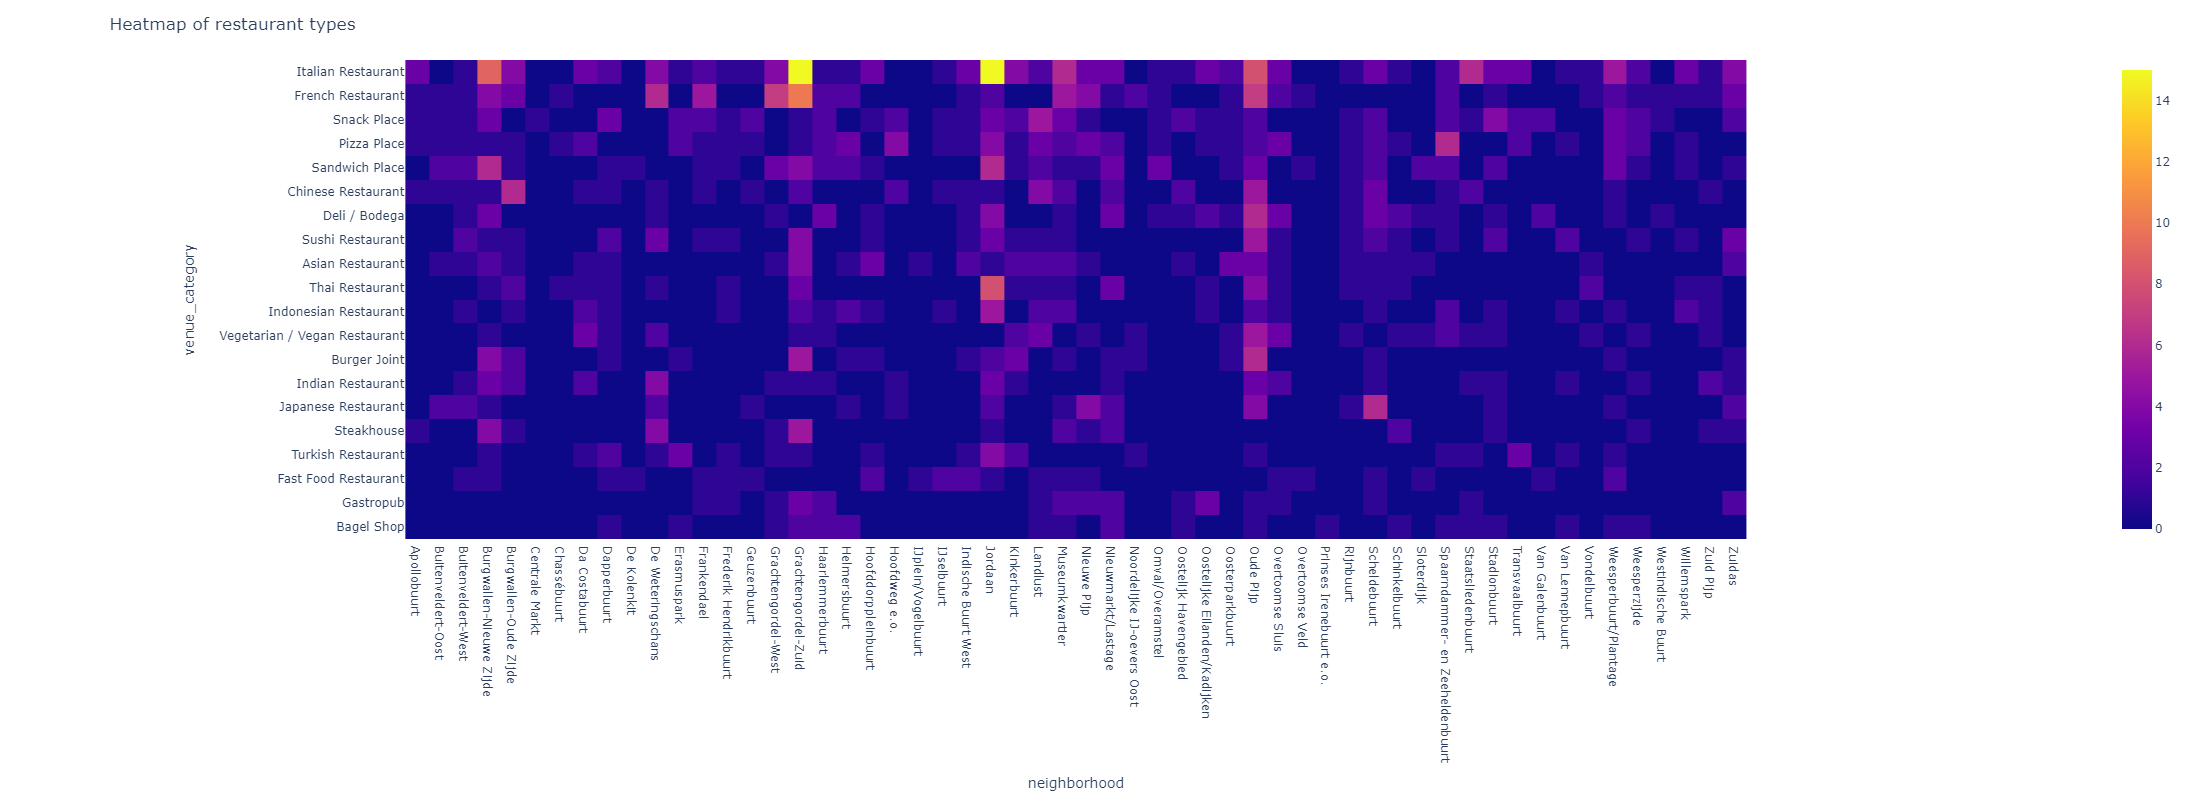

In [116]:
top_cats = total_cats.nlargest(20).index
heatmap = categories[top_cats]

import plotly.express as px

fig = px.imshow(heatmap.T)
fig.update_layout(
    title='Heatmap of restaurant types',
    width=2000,
    height=800,
    xaxis_nticks=99,
    yaxis_nticks=20)

fig.write_html('data/heatmap.html')
fig.show()

In [33]:
df_plot2 = df_geo3.set_index('Buurtcombinatie')

df_plot2['TotalRestaurants'] = totals
df_plot2['NumVegRestaurants'] = veg_rests
df_plot2['MostOccuring'] = mostoccurring

df_plot2.reset_index(inplace = True)

In [34]:
df_plot2.columns

Index(['Buurtcombinatie', 'Buurtcombinatie_code', 'Stadsdeel_code', 'Opp_m2',
       'geometry', 'center', 'long', 'lat', 'a_inw', 'perc_man', 'perc_woman',
       'perc_western', 'perc_not_western', 'perc_children', 'perc_youth',
       'perc_yup', 'perc_boomers', 'perc_elderly', 'bev_dich', 'g_hhgro',
       'PricePerM2', 'veiligheidsindex', 'criminaliteitsindex',
       'Onveiligheidsbeleving', 'TotalRestaurants', 'NumVegRestaurants',
       'MostOccuring'],
      dtype='object')

In [125]:
all_features = ['Buurtcombinatie', 'TotalRestaurants', 'MostOccuring', 'NumVegRestaurants', 'perc_man', 'perc_woman',
       'perc_western', 'perc_not_western', 'perc_children', 'perc_youth',
       'perc_yup', 'perc_boomers', 'perc_elderly', 'bev_dich', 'g_hhgro',
       'PricePerM2', 'veiligheidsindex', 'criminaliteitsindex',
       'Onveiligheidsbeleving']
aliases = ['Neighborhood', 'Total # Restaurants', 'Most occuring type', 'Number of Vegan / Vegatarian Restaurants', '% Men', '% Woman',
       '% Western', '% Non-Western', '% Children', '% Youth',
       '% Young Urban Professionals', '% Boomers', '% Eldery', 'Population Density', 'Average Household Size',
       'House price per m2', 'Safety Index', 'Criminality Index',
       'Perception of safety']

In [126]:
df_export = df_plot2[all_features]
df_export.columns = aliases
df_export.set_index('Neighborhood', inplace = True)

df_export_venue = venue_df[['venue', 'venue_category', 'neighborhood', 'venue_lat', 'venue_long']]
df_export_venue.columns = ['Restaurant name', 'Restaurant category', 'Neighborhood', 'Latitude', 'Longitude']


In [127]:
df_export_venue.to_pickle('data/venue_data.pickle')
df_export.to_pickle('data/neigh_data.pickle')

In [128]:
df_export_venue.head()

,Restaurant name,Restaurant category,Neighborhood,Latitude,Longitude
0,Jefferson Bar Brasserie,Restaurant,Hoofddorppleinbuurt,52.340269,4.844127
1,Oliver's Crazy Kitchen,Italian Restaurant,Hoofddorppleinbuurt,52.340771,4.844395
2,Salad Bowl Club,Salad Place,Hoofddorppleinbuurt,52.339045,4.843040
3,Lunchroom Etcetera,Cafeteria,Hoofddorppleinbuurt,52.339550,4.843908
4,by gusto,Breakfast Spot,Hoofddorppleinbuurt,52.340607,4.842670


In [129]:
def plot_map(df, tooltip, aliases, color_by, geometry = 'geometry', key = 'Buurtcombinatie', categorical = False, reverse = False, bins = 9, showtooltip = True, color_scheme = None):
    if color_scheme != None:
        fill_color = color_scheme
    else:
        if categorical:
            fill_color = 'Dark2'
        else:
            if reverse:
                fill_color = 'RdYlGn_r'
            else:
                fill_color = 'RdYlGn'
    
    
    m = folium.Map(location=[ams_latitude, ams_longitude],
                     zoom_start = 13, tiles='cartodbpositron')

    add_center = folium.Choropleth(
         geo_data= df[[geometry] + tooltip],
         data=df[[geometry] + tooltip],
         columns=[key, color_by], ##the columns containing the data
         key_on='properties.%s' %key,
         fill_color=fill_color, ##color style for the choropleth
         line_color = 'white',
         bins = bins,
         fill_opacity=0.5,
         line_opacity=1,
         legend_name=aliases[tooltip.index(color_by)], 
         highlight = True
    ).add_to(m)
    if showtooltip:
        add_center.geojson.add_child(
            folium.features.GeoJsonTooltip(tooltip, aliases = aliases, localize = True)
        )
    return m

In [130]:
color_by = 'NumVegRestaurants'
aliases[all_features.index(color_by)]

'Number of Vegan / Vegatarian Restaurants'

In [131]:
m = plot_map(df_plot2, all_features, aliases, color_by = 'TotalRestaurants', reverse=False, showtooltip=True)

venues = folium.GeoJson(venue_df, 
                        control = False,
                        marker = folium.CircleMarker(radius = 3, # Radius in metres
                                                     weight = 0, #outline weight
                                                     fill_color = 'black',
#                                                      style_function = lambda x: {'fillColor':'green' if x['venue_category'] == 'Vegetarian / Vegan Restaurant' else 'black','fillOpacity':0.75},
                                                     fill_opacity = 0.5),
                        tooltip = folium.GeoJsonTooltip(fields = ['venue', 'venue_category', 'neighborhood'],
                                                    aliases=['Name', 'Category', 'Neighborhood'],
                                                    style = ("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
                                                    sticky = True),
                        embed=True)

vegan = folium.GeoJson(venue_df.loc[venue_df.venue_category == 'Vegetarian / Vegan Restaurant'], 
                        control = False,
                        marker = folium.CircleMarker(radius = 6, # Radius in metres
                                                     weight = 0, #outline weight
                                                     fill_color = 'green',
                                                     line_color = 'green',
                                                     fill_opacity = 0.8),
                        tooltip = folium.GeoJsonTooltip(fields = ['venue', 'venue_category', 'neighborhood'],
                                                    aliases=['Name', 'Category', 'Neighborhood'],
                                                    style = ("background-color: black; color: white; font-family: arial; font-size: 12px; padding: 10px;"),
                                                    sticky = True),
                        embed=True)

m.add_child(venues)
m.add_child(vegan)

m.save('data/restaurants.html')

m

In [132]:
m = plot_map(df_plot2, all_features, aliases, color_by = 'bev_dich', reverse=False, showtooltip=False, color_scheme='Greys')

vegan = folium.GeoJson(venue_df.loc[venue_df.venue == 'Restaurant de Waaghals'], 
                        control = False,
                        marker = folium.CircleMarker(radius = 8, # Radius in metres
                                                     weight = 0, #outline weight
                                                     fill_color = 'red',
                                                     fill_opacity = 0.8),
                        tooltip = folium.GeoJsonTooltip(fields = ['venue', 'venue_category', 'neighborhood'],
                                                    aliases=['Name', 'Category', 'Neighborhood'],
                                                    style = ("background-color: black; color: white; font-family: arial; font-size: 12px; padding: 10px;"),
                                                    sticky = True),
                        embed=True)

m.add_child(vegan)

m.save('data/Waaghals.html')

m

## Clustering
### K-means clustering

In [134]:
features = [n for n in all_features if n != 'PricePerM2']

In [135]:
features

['Buurtcombinatie',
 'TotalRestaurants',
 'MostOccuring',
 'NumVegRestaurants',
 'perc_man',
 'perc_woman',
 'perc_western',
 'perc_not_western',
 'perc_children',
 'perc_youth',
 'perc_yup',
 'perc_boomers',
 'perc_elderly',
 'bev_dich',
 'g_hhgro',
 'veiligheidsindex',
 'criminaliteitsindex',
 'Onveiligheidsbeleving']

In [136]:
X = df_plot2[features].set_index('Buurtcombinatie')
X = X.merge(pd.get_dummies(X['MostOccuring']), left_index = True, right_index = True).drop('MostOccuring', axis = 1).fillna(0)

In [137]:
inertias = [] 
mapping = {} 
K = range(1,10) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, n_init=50, max_iter=600, tol=0.0001, random_state=0)
    kmeanModel.fit(X)

    inertias.append(kmeanModel.inertia_) 

    # Inertia
    mapping[k] = kmeanModel.inertia_

C:\Users\emcornelissen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [138]:
df_inertia = pd.DataFrame(index = K, data = inertias, columns = ['Inertia'])

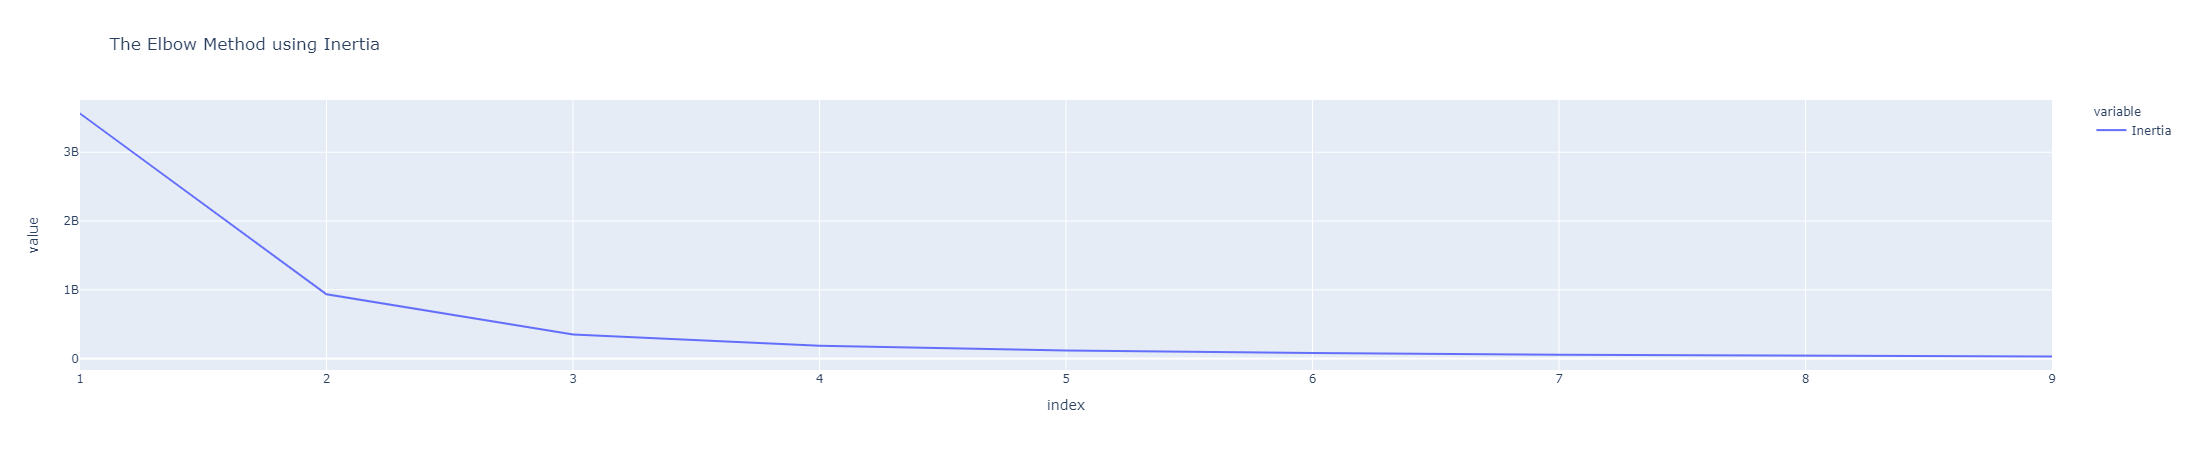

In [139]:
df_inertia.plot(title = 'The Elbow Method using Inertia')

In [141]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
df_plot2.insert(0, 'ClusterLabels', kmeans.labels_)
# df_plot2.reset_index(inplace = True)

In [142]:
df_plot2.head(2)

,ClusterLabels,Cluster Labels,Buurtcombinatie,Buurtcombinatie_code,Stadsdeel_code,Opp_m2,geometry,center,long,lat,a_inw,perc_man,perc_woman,perc_western,perc_not_western,perc_children,perc_youth,perc_yup,perc_boomers,perc_elderly,bev_dich,g_hhgro,PricePerM2,veiligheidsindex,criminaliteitsindex,Onveiligheidsbeleving,TotalRestaurants,NumVegRestaurants,MostOccuring
0,2,2,Burgwallen-Oude Zijde,A00,A,404733,"POLYGON ((4.90325 52.37658, 4.90298 52.37668, ...",POINT (4.89694 52.37255),4.896942,52.372553,4465.0,0.552072,0.447928,0.338186,0.174692,0.049272,0.155655,0.491601,0.210526,0.095185,12784.0,1.4,6030.0,178.10,102.01,106.73,73,0.0,Chinese Restaurant
1,4,4,Burgwallen-Nieuwe Zijde,A01,A,728412,"POLYGON ((4.90641 52.38003, 4.90601 52.38010, ...",POINT (4.89552 52.37569),4.895515,52.375692,4130.0,0.546005,0.453995,0.382567,0.179177,0.047215,0.148910,0.537530,0.190073,0.081114,7236.0,1.4,6502.0,168.84,117.20,96.95,106,1.0,Italian Restaurant


In [143]:
aliases

['Neighborhood',
 'Total # Restaurants',
 'Most occuring type',
 'Number of Vegan / Vegatarian Restaurants',
 '% Men',
 '% Woman',
 '% Western',
 '% Non-Western',
 '% Children',
 '% Youth',
 '% Young Urban Professionals',
 '% Boomers',
 '% Eldery',
 'Population Density',
 'Average Household Size',
 'House price per m2',
 'Safety Index',
 'Criminality Index',
 'Perception of safety']

In [144]:
tooltip2 = ['Buurtcombinatie',
             'TotalRestaurants',
             'NumVegRestaurants',
            'PricePerM2',
            'ClusterLabels']

aliases2 = ['Neighborhood',
             'Total # Restaurants',
             'Number of Vegan / Vegatarian Restaurants',
           'House price per m2',
           'Cluster']

In [145]:
cluster_num = df_plot2.loc[df_plot2.Buurtcombinatie == 'Oude Pijp']['ClusterLabels'].values[0]

In [146]:
m = plot_map(df_plot2, tooltip2, aliases2, color_by = 'ClusterLabels', geometry = 'geometry', key = 'Buurtcombinatie', categorical = True, reverse = False, bins = 5)
m.save('data/clusters.html')

In [148]:
m = plot_map(df_plot2.loc[df_plot2['ClusterLabels'] == cluster_num], tooltip2, aliases2, color_by = 'PricePerM2', geometry = 'geometry', key = 'Buurtcombinatie', reverse = True, bins = 6)
m.save('data/cluster0.html')
m
# plot_map(df_plot2.loc[df_plot2['Cluster Labels'] == cluster_num], tooltip2, aliases2, color_by = 'NumVegRestaurants', geometry = 'geometry', key = 'Buurtcombinatie', reverse = True, bins = 3)

# plot_map(df_plot2, tooltip2, aliases2, color_by = 'Cluster Labels', geometry = 'geometry', key = 'Buurtcombinatie', categorical = True, reverse = False, bins = 6)

In [160]:
df_exportcluster= df_plot2.loc[df_plot2['ClusterLabels'] == cluster_num][all_features]
df_exportcluster.columns = aliases
df_exportcluster.set_index('Neighborhood', inplace = True)

In [161]:
df_exportcluster.to_pickle('data/cluster.pickle')